# 03- Statistics Techniques

In [2]:
# Dependencies

# Standard Dependencies
import os
import numpy as np
import pandas as pd
from math import sqrt

# Visualization
from pylab import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from statistics import median
from scipy import signal
from math import factorial
import scipy.stats as stats
from scipy.stats import sem, binom, lognorm, poisson, bernoulli, spearmanr
from scipy.fftpack import fft, fftshift

# Scikit-learn for Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Seed for reproducability
seed = 12345
np.random.seed(seed)


# Read in csv of Toy Dataset
# We will use this dataset throughout the tutorial
df = pd.read_csv('../data/toy_dataset.csv')

## Table of contents

- [Linear Regression](#9)
  - Anscombe's Quartet
- [Bootstrapping](#10)
- [Hypothesis Testing](#11)
  - p-value
  - q-q plot
- [Outliers](#12)
  - Grubbs Test
  - Tukey's Method

## Linear regression <a id="9"></a>

Linear Regression can be performed through Ordinary Least Squares (OLS) or Maximum Likelihood Estimation (MLE).

Most Python libraries use OLS to fit linear models.

![](https://image.slidesharecdn.com/simplelinearregressionpelatihan-090829234643-phpapp02/95/simple-linier-regression-9-728.jpg?cb=1251589640)

/home/ubuntu/Documents/Projects/msci_data/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Well fitted but not well fitting: Linear regression plot on quadratic data'}>

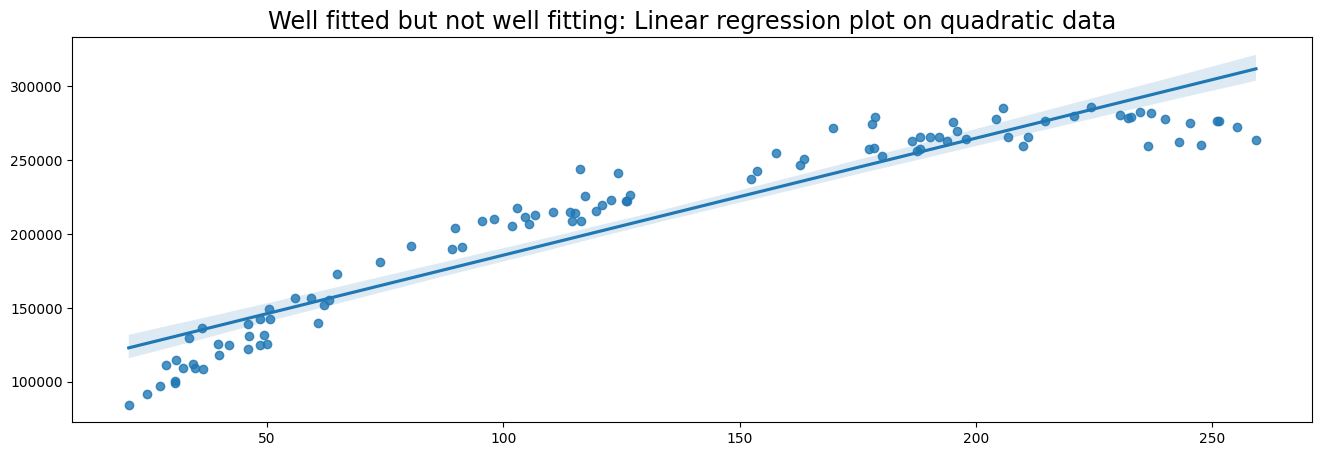

In [25]:
# Generate data
x = np.random.uniform(low=20, high=260, size=100)
y = 50000 + 2000*x - 4.5 * x**2 + np.random.normal(size=100, loc=0, scale=10000)

# Plot data with Linear Regression
plt.figure(figsize=(16,5))
plt.title('Well fitted but not well fitting: Linear regression plot on quadratic data', fontsize='xx-large')
sns.regplot(x, y)

Here we observe that the linear model is well-fitted. However, a linear model is probably not ideal for our data, because the data follows a quadratic pattern. A [polynomial regression model](https://en.wikipedia.org/wiki/Polynomial_regression) would better fit the data, but this is outside the scope of this tutorial.

We can also implement linear regression with a bare-bones approach. In the following example we measure the vertical distance and horizontal distance between a random data point and the regression line. 

For more information on implementing linear regression from scratch [I highly recommend this explanation by Luis Serrano](https://aitube.io/video/introduction-to-linear-regression).

Slope: 5.088945016552908
Intercept: -8.566631021731279


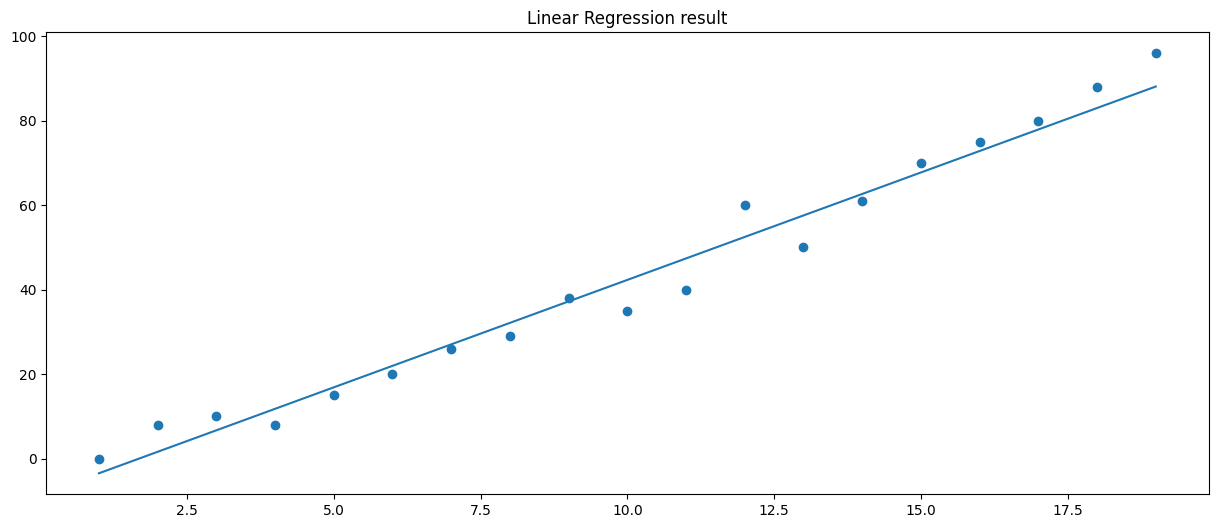

In [26]:
# Linear regression from scratch
import random
# Create data from regression
xs = np.array(range(1,20))
ys = [0,8,10,8,15,20,26,29,38,35,40,60,50,61,70,75,80,88,96]

# Put data in dictionary
data = dict()
for i in list(xs):
    data.update({xs[i-1] : ys[i-1]})

# Slope
m = 0
# y intercept
b = 0
# Learning rate
lr = 0.0001
# Number of epochs
epochs = 100000

# Formula for linear line
def lin(x):
    return m * x + b

# Linear regression algorithm
for i in range(epochs):
    # Pick a random point and calculate vertical distance and horizontal distance
    rand_point = random.choice(list(data.items()))
    vert_dist = abs((m * rand_point[0] + b) - rand_point[1])
    hor_dist = rand_point[0]

    if (m * rand_point[0] + b) - rand_point[1] < 0:
        # Adjust line upwards
        m += lr * vert_dist * hor_dist
        b += lr * vert_dist   
    else:
        # Adjust line downwards
        m -= lr * vert_dist * hor_dist
        b -= lr * vert_dist
        
# Plot data points and regression line
plt.figure(figsize=(15,6))
plt.scatter(data.keys(), data.values())
plt.plot(xs, lin(xs))
plt.title('Linear Regression result')  
print('Slope: {}\nIntercept: {}'.format(m, b))

The coefficients of a linear model can also be computed using MSE (Mean Squared Error) without an iterative approach. I implemented Python code for this technique as well. The code is in [the second cell of this Github repository](https://github.com/CarloLepelaars/linreg/blob/master/linreg_from_scratch.ipynb)

### Anscombe's Quartet

Anscombe's quartet is a set of four datasets that have the same descriptive statistics and linear regression fit. The datasets are however very different from each other.

This sketches the issue that although summary statistics and regression models are really helpful in understanding your data, you should always visualize the data to see whats really going on. It also shows that a few outliers can really mess up your model.

[More information on Anscombe's Quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)

![](https://www.researchgate.net/profile/Arch_Woodside2/publication/286454889/figure/fig3/AS:669434310037526@1536616985820/Anscombes-quartet-of-different-XY-plots-of-four-data-sets-having-identical-averages.png)

## Bootstrapping <a id="10"></a>

Bootstrapping is a resampling technique to quantify the uncertainty of an estimator given sample data. In other words, we have a sample of data and we take multiple samples from that sample. For example, with bootstrapping we can take means for each bootstrap sample and thereby make a distribution of means.

Once we created a distribution of estimators we can use this to make decisions. 

Bootstrapping can be:
1. Non-parametric (Take random samples from sample)
2. Parametric (Take from a (normal) distribution with sample mean and variance).
    Downside: You are making assumptions about the distribution.
    Upside: Computationally more light
3. Online bootstrap (Take samples from a stream of data)

The following code implements a simple non-parametric bootstrap to create a distribution of means, medians and midranges of the Income distribution in our Toy Dataset. We can use this to deduce which income means will make sense for subsequent samples.


Bootstrap Sample: 
128037     66336.0
5192       51638.0
50057     106578.0
109259    120964.0
73349     103441.0
Name: Income, dtype: float64

Mean of the population:  91252.79827333333
Standard Deviation of the population:  24989.500948354904


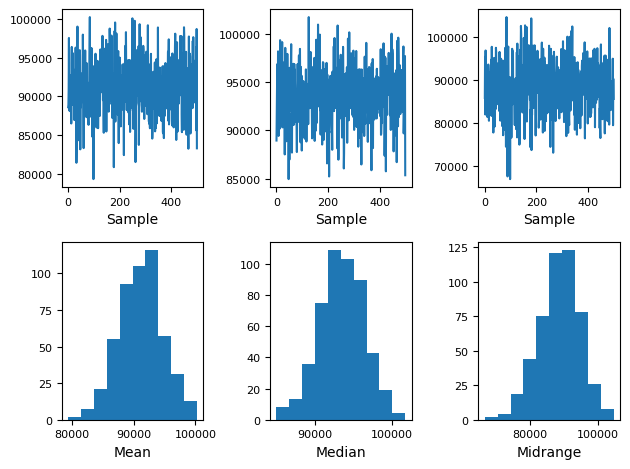

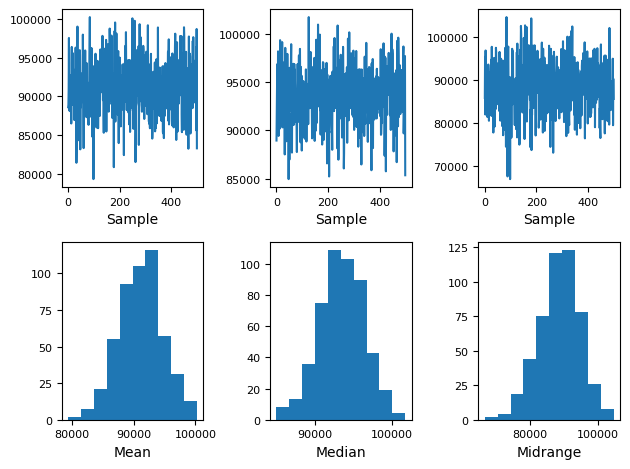

In [27]:
# scikit-learn bootstrap package
from sklearn.utils import resample

# data sample
data = df['Income']

# prepare bootstrap samples
boot = resample(data, replace=True, n_samples=5, random_state=1)
print('Bootstrap Sample: \n{}\n'.format(boot))
print('Mean of the population: ', data.mean())
print('Standard Deviation of the population: ', data.std())

# Bootstrap plot
pd.plotting.bootstrap_plot(data)

## Hypothesis testing <a id="11"></a>

We establish two hypotheses, H0 (Null hypothesis) and Ha (Alternative Hypothesis). 

We can make four different decisions with hypothesis testing:
1. Reject H0 and H0 is not true (no error)
2. Do not reject H0 and H0 is true (no error)
3. Reject H0 and H0 is true (Type 1 Error)
4. Do not reject H0 and H0 is not true (Type 2 error)

Type 1 error is also called Alpha error.
Type 2 error is also called Beta error.

![](https://qph.fs.quoracdn.net/main-qimg-84121cf5638cbb5919999b2a8d928c91)

![](https://i.stack.imgur.com/x1GQ1.png)

### P-Value

A p-value is the probability of finding equal or more extreme results when the null hyptohesis (H0) is true. In other words, a low p-value means that we have compelling evidence to reject the null hypothesis.

If the p-value is lower than 5% (p < 0.05). We often reject H0 and accept Ha is true. We say that p < 0.05 is statistically significant, because there is less than 5% chance that we are wrong in rejecting the null hypothesis.

One way to calculate the p-value is through a T-test. We can use [Scipy's ttest_ind function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) to calculate the t-test for the means of two independent samples of scores. In this example we calculate the t-statistic and p-value of two random samples 10 times. 

We see that the p-value is sometimes very low, but this does not mean that these two random samples are correlated. This is why you have to be careful with relying too heavily of p-values. If you repeat an experiment multiple times you can get trapped in the illusion that there is correlation where there is only randomness.

[This xkcd comic perfectly illustrates the hazards of relying too much on p-values](https://xkcd.com/882/).

In [28]:
# Perform t-test and compute p value of two random samples
print('T-statistics and p-values of two random samples.')
for _ in range(10):
    rand_sample1 = np.random.random_sample(10)
    rand_sample2 = np.random.random_sample(10)
    print(stats.ttest_ind(rand_sample1, rand_sample2))

T-statistics and p-values of two random samples.
Ttest_indResult(statistic=-1.719961210931469, pvalue=0.10258607798078974)
Ttest_indResult(statistic=0.11611498231792595, pvalue=0.9088470714024377)
Ttest_indResult(statistic=0.08008385658103984, pvalue=0.9370542331721071)
Ttest_indResult(statistic=-1.9967692404975275, pvalue=0.061200345217428384)
Ttest_indResult(statistic=-0.6479853089913131, pvalue=0.5251745713434512)
Ttest_indResult(statistic=-0.7623766875402467, pvalue=0.4557101187432995)
Ttest_indResult(statistic=0.05992761577798024, pvalue=0.9528736308812027)
Ttest_indResult(statistic=1.2824768978093535, pvalue=0.2159459003335804)
Ttest_indResult(statistic=-0.08626056290370392, pvalue=0.9322115927100924)
Ttest_indResult(statistic=0.6402229152061815, pvalue=0.5300937533693708)


In [29]:
# To-do
# Equivalence testing

### q-q plot (quantile-quantile plot)

Many statistical techniques require that data is coming from a normal distribution (for example, t-test). Therefore, it is important to verify this before applying statistical techniques.

One approach is to visualize and make a judgment about the distribution. A q-q plot is very helpful for determining if a distribution is normal. There are other tests for testing 'normality', but this is beyond the scope of this tutorial.

In the first plot we can easily see that the values line up nicely. From this we conclude that the data is normally distributed.

In the second plot we can see that the values don't line up. Our conclusion is that the data is not normally distributed. In this case the data was uniformly distributed.


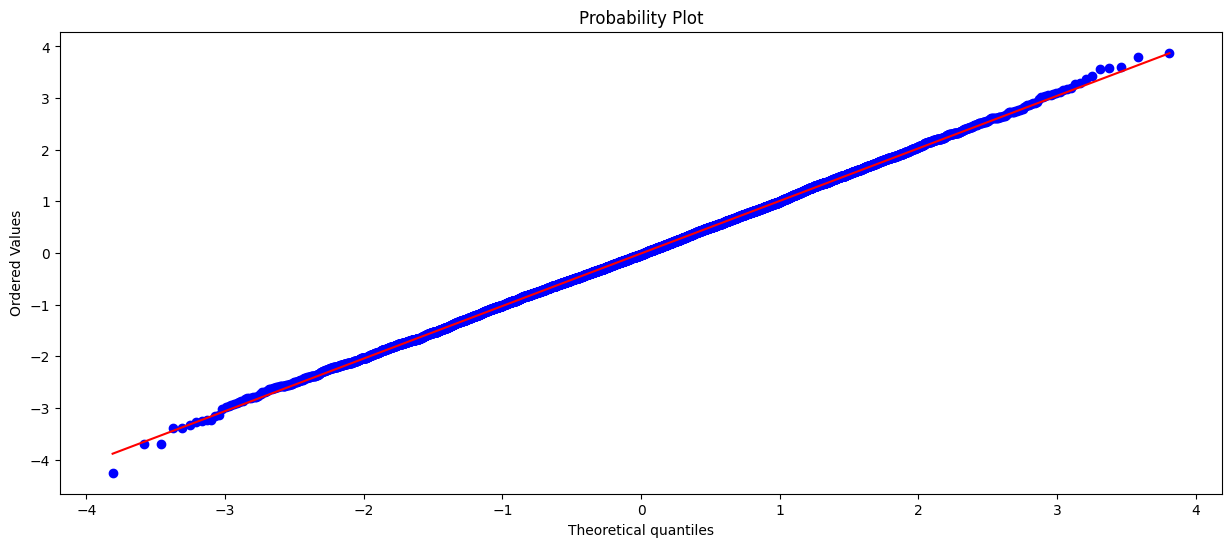

In [30]:
# q-q plot of a normal distribution
plt.figure(figsize=(15,6))
stats.probplot(normal_dist, dist="norm", plot=plt)
plt.show()

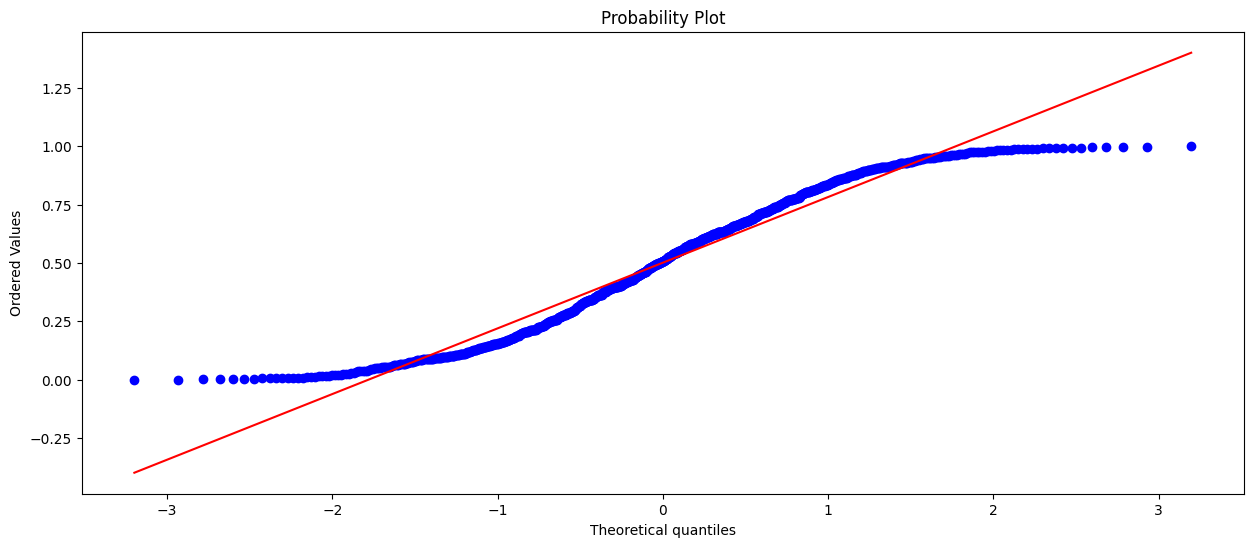

In [31]:
# q-q plot of a uniform/random distribution
plt.figure(figsize=(15,6))
stats.probplot(uniform_dist, dist="norm", plot=plt) 
plt.show()

## Outliers <a id="12"></a>

An outlier is an observation which deviates from other observations. An outlier often stands out and could be an error.

Outliers can mess up you statistical models. However, outliers should only be removed when you have established good reasons for removing the outlier.

Sometimes the outliers are the main topic of interest. This is for example the case with fraud detection. There are many outlier detection methods, but here we will discuss Grubbs test and Tukey’s method. Both tests assume that the data is normally distributed.

### Grubbs Test

In Grubbs test, the null hypothesis is that no observation is an outlier, while the alternative hypothesis is that there is one observation an outlier. Thus the Grubbs test is only searching for one outlier observation.

The formula for Grubbs test:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/bafc310f1dbca658728c73256fed19b6a7f11130)

Where Y_hat is the sample mean and s is the standard deviation. The Grubbs test statistic is the largest absolute deviation from the sample mean in units of the sample standard deviation.

[Source](https://en.wikipedia.org/wiki/Grubbs%27_test_for_outliers)

### Tukey's method

Tukey suggested that an observation is an outlier whenever an observation is 1.5 times the interquartile range below the first quartile or 1.5 times the interquartile range above the third quartile. This may sound complicated, but is quite intuitive if you see it visually.

For normal distributions, Tukey’s criteria for outlier observations is unlikely if no outliers are present, but using Tukey’s criteria for other distributions should be taken with a grain of salt.

The formula for Tukey's method:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2a103bbd9233d9f8f711a7c76dfeb9694446f860)

Ya is the larger of two means being compared. SE is the standard error of the sum of the means.

[Source](https://en.wikipedia.org/wiki/Tukey%27s_range_test)

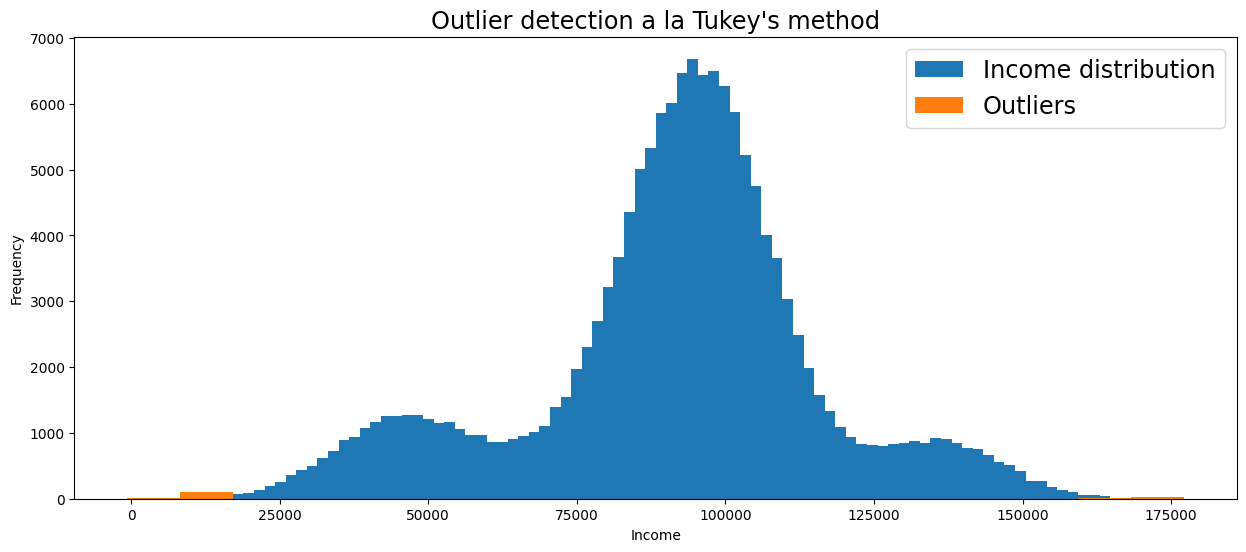

In [32]:
# Detect outliers on the 'Income' column of the Toy Dataset

# Function for detecting outliers a la Tukey's method using z-scores
def tukey_outliers(data) -> list:
    # For more information on calculating the threshold check out:
    # https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32
    threshold = 3
    
    mean = np.mean(data)
    std = np.std(data)
    
    # Spot and collect outliers
    outliers = []
    for i in data:
        z_score = (i - mean) / std
        if abs(z_score) > threshold:
            outliers.append(i)
    return outliers

# Get outliers
income_outliers = tukey_outliers(df['Income'])

# Visualize distribution and outliers
plt.figure(figsize=(15,6))
df['Income'].plot(kind='hist', bins=100, label='Income distribution')
plt.hist(income_outliers, bins=20, label='Outliers')
plt.title("Outlier detection a la Tukey's method", fontsize='xx-large')
plt.xlabel('Income')
plt.legend(fontsize='xx-large')